<a href="https://colab.research.google.com/github/luisfelipevalenca/Algorithms-Studying/blob/main/Quantum_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Following Class

#import libraries
import numpy as np

#define the shape of the environment (i.e., its states)
environment_rows = 11
environment_columns = 11

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 11 rows and 11 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_values = np.zeros((environment_rows, environment_columns, 4))


#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

#Create a 2D numpy array to hold the rewards for each state.
#The array contains 11 rows and 11 columns (to match the shape of the environment), and each value is initialized to -100.
rewards = np.full((environment_rows, environment_columns), -100.)
rewards[0, 5] = 100. #set the reward for the packaging area (i.e., the goal) to 100

#define aisle locations (i.e., white squares) for rows 1 through 9
aisles = {} #store locations in a dictionary
aisles[1] = [i for i in range(1, 10)]
aisles[2] = [1, 7, 9]
aisles[3] = [i for i in range(1, 8)]
aisles[3].append(9)
aisles[4] = [3, 7]
aisles[5] = [i for i in range(11)]
aisles[6] = [5]
aisles[7] = [i for i in range(1, 10)]
aisles[8] = [3, 7]
aisles[9] = [i for i in range(11)]

#set the rewards for all aisle locations (i.e., white squares)
for row_index in range(1, 10):
  for column_index in aisles[row_index]:
    rewards[row_index, column_index] = -1.

#print rewards matrix
for row in rewards:
  print(row)

#define a function that determines if the specified location is a terminal state
def is_terminal_state(current_row_index, current_column_index):
  #if the reward for this location is -1, then it is not a terminal state (i.e., it is a 'white square')
  if rewards[current_row_index, current_column_index] == -1.:
    return False
  else:
    return True

#define a function that will choose a random, non-terminal starting location
def get_starting_location():
  #get a random row and column index
  current_row_index = np.random.randint(environment_rows)
  current_column_index = np.random.randint(environment_columns)
  #continue choosing random row and column indexes until a non-terminal state is identified
  #(i.e., until the chosen state is a 'white square').
  while is_terminal_state(current_row_index, current_column_index):
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
  return current_row_index, current_column_index

#define an epsilon greedy algorithm that will choose which action to take next (i.e., where to move next)
def get_next_action(current_row_index, current_column_index, epsilon):
  #if a randomly chosen value between 0 and 1 is less than epsilon,
  #then choose the most promising value from the Q-table for this state.
  if np.random.random() < epsilon:
    return np.argmax(q_values[current_row_index, current_column_index])
  else: #choose a random action
    return np.random.randint(4)

#define a function that will get the next location based on the chosen action
def get_next_location(current_row_index, current_column_index, action_index):
  new_row_index = current_row_index
  new_column_index = current_column_index
  if actions[action_index] == 'up' and current_row_index > 0:
    new_row_index -= 1
  elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
    new_column_index += 1
  elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
    new_row_index += 1
  elif actions[action_index] == 'left' and current_column_index > 0:
    new_column_index -= 1
  return new_row_index, new_column_index

#Define a function that will get the shortest path between any location within the warehouse that
#the robot is allowed to travel and the item packaging location.
def get_shortest_path(start_row_index, start_column_index):
  #return immediately if this is an invalid starting location
  if is_terminal_state(start_row_index, start_column_index):
    return []
  else: #if this is a 'legal' starting location
    current_row_index, current_column_index = start_row_index, start_column_index
    shortest_path = []
    shortest_path.append([current_row_index, current_column_index])
    #continue moving along the path until we reach the goal (i.e., the item packaging location)
    while not is_terminal_state(current_row_index, current_column_index):
      #get the best action to take
      action_index = get_next_action(current_row_index, current_column_index, 1.)
      #move to the next location on the path, and add the new location to the list
      current_row_index, current_column_index = get_next_location(current_row_index, current_column_index, action_index)
      shortest_path.append([current_row_index, current_column_index])
    return shortest_path

#define training parameters
epsilon = 0.9 #the percentage of time when we should take the best action (instead of a random action)
discount_factor = 0.9 #discount factor for future rewards
learning_rate = 0.9 #the rate at which the AI agent should learn

#run through 1000 training episodes
for episode in range(1000):
  #get the starting location for this episode
  row_index, column_index = get_starting_location()

  #continue taking actions (i.e., moving) until we reach a terminal state
  #(i.e., until we reach the item packaging area or crash into an item storage location)
  while not is_terminal_state(row_index, column_index):
    #choose which action to take (i.e., where to move next)
    action_index = get_next_action(row_index, column_index, epsilon)

    #perform the chosen action, and transition to the next state (i.e., move to the next location)
    old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
    row_index, column_index = get_next_location(row_index, column_index, action_index)

    #receive the reward for moving to the new state, and calculate the temporal difference
    reward = rewards[row_index, column_index]
    old_q_value = q_values[old_row_index, old_column_index, action_index]
    temporal_difference = reward + (discount_factor * np.max(q_values[row_index, column_index])) - old_q_value

    #update the Q-value for the previous state and action pair
    new_q_value = old_q_value + (learning_rate * temporal_difference)
    q_values[old_row_index, old_column_index, action_index] = new_q_value

print('Training complete!')

#display a few shortest paths
print(get_shortest_path(3, 9)) #starting at row 3, column 9
print(get_shortest_path(5, 0)) #starting at row 5, column 0
print(get_shortest_path(9, 5)) #starting at row 9, column 5


#display an example of reversed shortest path
path = get_shortest_path(5, 2) #go to row 5, column 2
path.reverse()
print(path)

[-100. -100. -100. -100. -100.  100. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100.   -1. -100. -100. -100. -100. -100.   -1. -100.   -1. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100.   -1. -100. -100. -100. -100. -100.]
[-100.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1.   -1. -100.]
[-100. -100. -100.   -1. -100. -100. -100.   -1. -100. -100. -100.]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
Training complete!
[[3, 9], [2, 9], [1, 9], [1, 8], [1, 7], [1, 6], [1, 5], [0, 5]]
[[5, 0], [5, 1], [5, 2], [5, 3], [4, 3], [3, 3], [3, 2], [3, 1], [2, 1], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [0, 5]]
[[9, 5], [9, 4], [9, 3], [8, 3], [7, 3], [7, 4], [7, 5], [6, 5], [5, 5], [5, 6], [5, 7], [4

In [12]:
# Concepts

# Quantum State Representation: The states of the environment, which are classical data, need to be encoded into quantum states. This process is known as quantum embedding.
# Quantum Circuit for Action Selection: Design a quantum circuit that takes the quantum state as input and outputs a superposition of actions with their amplitudes related to their Q-values. Measurement of this circuit's output then probabilistically gives you an action to take, with higher Q-value actions being more likely.
# Quantum Experience Replay: The experience replay buffer might also be stored and processed quantum-mechanically, allowing for more efficient sampling and memory usage.
# Hybrid Training: The training might involve a hybrid approach, where certain calculations are performed on a classical computer (like environment simulation), while the quantum computer handles the Q-value computation and optimization.
#!pip install cirq
import cirq

# Create a quantum circuit
qubit = cirq.GridQubit(1, 1)  # Define a qubit at grid position 0,0
circuit = cirq.Circuit(
    cirq.X(qubit)**0.5,  # Apply a square root of NOT gate
    cirq.measure(qubit, key='result')  # Measure the qubit
)

# Display the circuit
print("Circuit:")
print(circuit)

# Simulate the circuit
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)

# Print the results
print("Results:")
print(result)


Circuit:
(1, 1): ───X^0.5───M('result')───
Results:
result=1111010101


In [ ]:
# Implementing mine

import cirq
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import Conv2D, Flatten, MaxPooling2D, BatchNormalization, Reshape


# Function to evaluate the model
def evaluate_model(model, X_test, y_test, scaler, model_name):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)
    mse = mean_squared_error(y_test_inv, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_test_inv, y_pred, multioutput='raw_values')
    print(f"{model_name} - MSE por junta: {mse}")
    print(f"{model_name} - MAE por junta: {mae}\n")

# Load and prepare the data
df = pd.read_csv('/content/help(v4).csv', encoding='utf8')

# Define inputs and outputs
total_columns = df.shape[1]
num_labels = 6  # Number of labels
num_features = total_columns - num_labels

X = df.iloc[:, :num_features]
y = df.iloc[:, -num_labels:]

# Normalization
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

X_s = x_scaler.fit_transform(X)
y_s = y_scaler.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2)

# Define the quantum circuit
def create_quantum_circuit(repetitions=200):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit(cirq.H(qubit), cirq.measure(qubit, key='result'))
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)
    measurements = result.measurements['result']
    return np.array(measurements).astype(np.float32).flatten()

# Generate quantum features for training data
quantum_features_train = create_quantum_circuit(repetitions=X_train.shape[0])

# Integrate quantum features with training data
X_train_quantum = np.hstack((X_train, quantum_features_train.reshape(-1, 1)))

# Define and compile the MLP model
def build_mlp_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2048, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        tf.keras.layers.Dense(output_shape, activation='linear')
    ])
    model.compile(optimizer=Adam(0.000005), loss='mean_squared_error', metrics=['accuracy'])
    return model

mlp_model = build_mlp_model(input_shape=X_train_quantum.shape[1], output_shape=y_train.shape[1])

# Train the MLP model
history = mlp_model.fit(X_train_quantum, y_train, epochs=200, validation_split=0.2)

# Plotting the training history
plt.figure()
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE per Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Generate quantum features for test data
quantum_features_test = create_quantum_circuit(repetitions=X_test.shape[0])

# Integrate quantum features with test data
X_test_quantum = np.hstack((X_test, quantum_features_test.reshape(-1, 1)))

# Evaluate the model with the test data
evaluate_model(mlp_model, X_test_quantum, y_test, y_scaler, "MLP Model")


Epoch 1/100
200/200 [==============================] - 1s 2ms/step - loss: 0.1166 - accuracy: 0.6077 - val_loss: 0.0270 - val_accuracy: 0.7987
Epoch 2/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0171 - accuracy: 0.8248 - val_loss: 0.0115 - val_accuracy: 0.8600
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 0.8698 - val_loss: 0.0068 - val_accuracy: 0.8913
Epoch 4/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.8931 - val_loss: 0.0048 - val_accuracy: 0.9112
Epoch 5/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.9136 - val_loss: 0.0038 - val_accuracy: 0.9169
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 0.9261 - val_loss: 0.0030 - val_accuracy: 0.9225
Epoch 7/100
200/200 [==============================] - 0s 1ms/step - loss: 0.0025 - accuracy: 0.9302 - val_loss: 0.0025 - val_accuracy: 0.9381

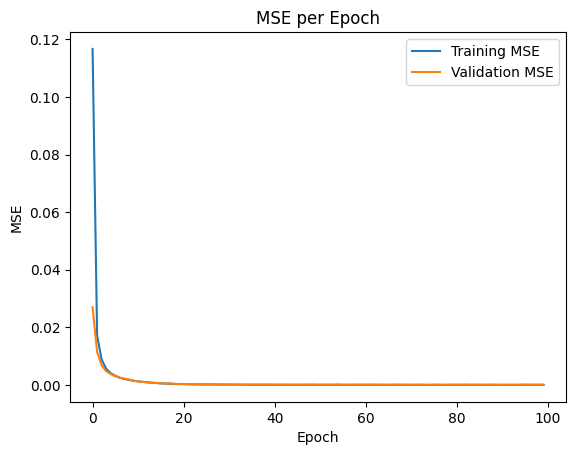

63/63 [==============================] - 0s 897us/step
MLP Model - MSE por junta: [0.00036475 0.00017115 0.00022399 0.00093359 0.0002458  0.00097487]
MLP Model - MAE por junta: [0.0138168  0.01022663 0.01172963 0.02225751 0.01233634 0.02155299]



In [6]:
import cirq
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Function to evaluate the model
def evaluate_model(model, X_test, y_test, scaler, model_name):
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)
    mse = mean_squared_error(y_test_inv, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_test_inv, y_pred, multioutput='raw_values')
    print(f"{model_name} - MSE por junta: {mse}")
    print(f"{model_name} - MAE por junta: {mae}\n")

# Load and prepare the data
df = pd.read_csv('/content/Dataset_enhanced_Gaussiano_sem_Angulo_e_TransPoly_Normalizados.csv', encoding='utf8')

# Define inputs and outputs
total_columns = df.shape[1]
num_labels = 6  # Number of labels
num_features = total_columns - num_labels

X = df.iloc[:, :num_features]
y = df.iloc[:, -num_labels:]

# Normalization
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

X_s = x_scaler.fit_transform(X)
y_s = y_scaler.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2)

# Define the quantum circuit
def create_quantum_circuit(repetitions=200):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit(cirq.H(qubit), cirq.measure(qubit, key='result'))
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=repetitions)
    measurements = result.measurements['result']
    return np.array(measurements).astype(np.float32).flatten()

# Generate quantum features for training data
quantum_features_train = create_quantum_circuit(repetitions=X_train.shape[0])

# Integrate quantum features with training data
X_train_quantum = np.hstack((X_train, quantum_features_train.reshape(-1, 1)))

# Define and compile the MLP model
def build_mlp_model(input_shape, output_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(input_shape,)),
        tf.keras.layers.Dense(125, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(output_shape, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

mlp_model = build_mlp_model(input_shape=X_train_quantum.shape[1], output_shape=y_train.shape[1])

# Train the MLP model
history = mlp_model.fit(X_train_quantum, y_train, epochs=100, validation_split=0.2)

# Plotting the training history
plt.figure()
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE per Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Generate quantum features for test data
quantum_features_test = create_quantum_circuit(repetitions=X_test.shape[0])

# Integrate quantum features with test data
X_test_quantum = np.hstack((X_test, quantum_features_test.reshape(-1, 1)))

# Evaluate the model with the test data
evaluate_model(mlp_model, X_test_quantum, y_test, y_scaler, "MLP Model")
